In [3]:
import pandas as pd
import seaborn as sns
from detector import TRAINING_FILEPATH
from os.path import join
import os
import matplotlib.pyplot as plt
from itertools import product

metadata = pd.read_csv(join(TRAINING_FILEPATH, 'METADATA.csv'))

def get_df(base_path, add_var_name='lambda', add_var_val=1):
    df_list = []
    model_id_list = []
    for f in [p for p in os.listdir(base_path) if '.csv' in p]:
        temp_df = pd.read_csv(join(base_path, f), index_col=0)
        temp_df = temp_df.transpose()
        temp_df['model_name'] = 'id-'+str(100000000 + int(f.split('.')[0]))[1:]
        df_list.append(temp_df)
    results_df = pd.concat(df_list)
    results_df = results_df.reset_index(drop=False)
    results_df[add_var_name] = add_var_val

    # merge results with metadata
    results_df = results_df.merge(metadata, how='left', on='model_name')
    results_df = results_df.sort_values('trigger_option')
    arch_map = {
    'roberta-base':'Roberta',
    'google/electra-small-discriminator' :'Electra',
    'deepset/roberta-base-squad2':'Roberta Squad'
    }
    results_df['test_clean_loss'] = results_df['test_clean_loss'].astype(float)
    results_df = results_df.replace(to_replace=arch_map)
    return results_df

def get_details_df(base_path, layer_type='LAYER_TYPE.EMBEDDING', add_var_val=1):
    df_list = []
    model_id_list = []
    for f in [p for p in os.listdir(base_path) if '.csv' in p]:
        temp_df = pd.read_csv(join(base_path, f), index_col=0)
        # temp_df = temp_df[temp_df['layer_type']==layer_type]
        # temp_df = temp_df.iloc[[0]]
        temp_df['model_name'] = 'id-'+str(100000000 + int(f.split('.')[0]))[1:]
        df_list.append(temp_df)
    results_df = pd.concat(df_list)

    # merge results with metadata
    results_df = results_df.merge(metadata, how='left', on='model_name')
    results_df = results_df.sort_values('trigger_option')
    arch_map = {
    'roberta-base':'Roberta',
    'google/electra-small-discriminator' :'Electra',
    'deepset/roberta-base-squad2':'Roberta Squad'
    }
    results_df['test_clean_loss'] = results_df['test_clean_loss'].astype(float)
    results_df = results_df.replace(to_replace=arch_map)
    return results_df

details_df = get_details_df('ww_details')
df = get_df('ww_summary')

## We cannot do the same analysis as CV

<AxesSubplot:xlabel='alpha_weighted', ylabel='test_clean_f1_score'>

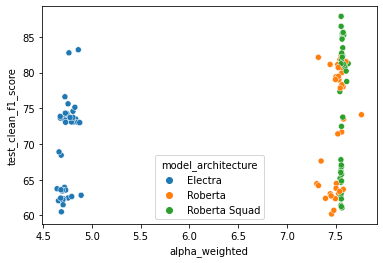

In [48]:
sns.scatterplot(data=df, x='alpha_weighted', y='test_clean_f1_score', hue='model_architecture')

## Very hard to see any trend

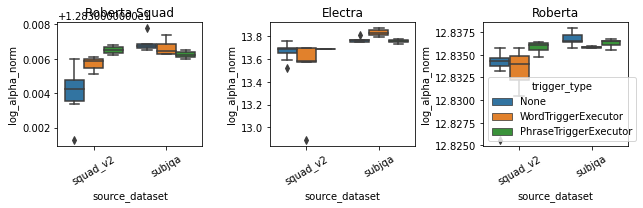

In [96]:
fig, axs = plt.subplots(1,3, figsize=(9,3))
for i, arch in enumerate(details_df['model_architecture'].unique()):
    ax = axs[i]
    sns.boxplot(data=details_df[details_df['model_architecture']==arch], x='source_dataset', y='log_alpha_norm', hue='trigger_type', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'{arch}')
    if i < 2:
        ax.get_legend().remove()
plt.tight_layout()

missing models: 0


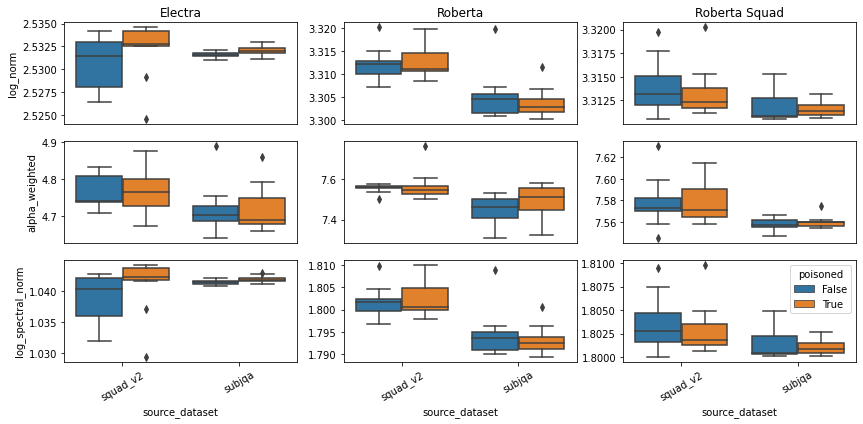

In [99]:
print(f'missing models: {len(metadata)-len(df)}')

fig, axs = plt.subplots(3,3, figsize=(12,6))
for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[0, i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='log_norm', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'{arch}')
    if i > 0:
        ax.set_ylabel('')

    ax.get_legend().remove()
    ax.set_xticks([])
    ax.set_xlabel('')

for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[1, i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='alpha_weighted', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    if i > 0:
        ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.get_legend().remove()

for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[2, i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='log_spectral_norm', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    if i > 0:
        ax.set_ylabel('')
    if i < 2:
        ax.get_legend().remove()
plt.tight_layout()
plt.savefig('ww_prelim.pdf', dpi=2000)

In [9]:
from pandas.plotting import table

# fig, ax = plt.subplots(1,1)
print(details_df.groupby(['model_architecture', 'source_dataset', 'poisoned']).agg({'alpha':'mean', 'test_clean_f1_score':'mean'}).round(2).to_latex())

\begin{tabular}{lllrr}
\toprule
              &        &       &  alpha &  test\_clean\_f1\_score \\
model\_architecture & source\_dataset & poisoned &        &                      \\
\midrule
Electra & squad\_v2 & False &   4.90 &                73.97 \\
              &        & True  &   4.89 &                74.00 \\
              & subjqa & False &   4.76 &                62.71 \\
              &        & True  &   4.76 &                69.10 \\
Roberta & squad\_v2 & False &   4.29 &                80.60 \\
              &        & True  &   4.33 &                79.48 \\
              & subjqa & False &   4.57 &                62.91 \\
              &        & True  &   4.55 &                69.97 \\
Roberta Squad & squad\_v2 & False &   4.29 &                83.72 \\
              &        & True  &   4.29 &                82.15 \\
              & subjqa & False &   4.31 &                63.95 \\
              &        & True  &   4.30 &                68.02 \\
\bottomrule
\end{

|                                      |   alpha |   test_clean_f1_score |
|:-------------------------------------|--------:|----------------------:|
| ('Electra', 'squad_v2', False)       | 4.90494 |               73.9677 |
| ('Electra', 'squad_v2', True)        | 4.88996 |               73.9979 |
| ('Electra', 'subjqa', False)         | 4.75826 |               62.7073 |
| ('Electra', 'subjqa', True)          | 4.75908 |               69.1032 |
| ('Roberta', 'squad_v2', False)       | 4.28537 |               80.6031 |
| ('Roberta', 'squad_v2', True)        | 4.32822 |               79.4814 |
| ('Roberta', 'subjqa', False)         | 4.57345 |               62.9055 |
| ('Roberta', 'subjqa', True)          | 4.54968 |               69.9736 |
| ('Roberta Squad', 'squad_v2', False) | 4.29207 |               83.7202 |
| ('Roberta Squad', 'squad_v2', True)  | 4.29262 |               82.1452 |
| ('Roberta Squad', 'subjqa', False)   | 4.3069  |               63.9516 |
| ('Roberta Squad', 'subjqa', True)    | 4.303   |               68.0242 |

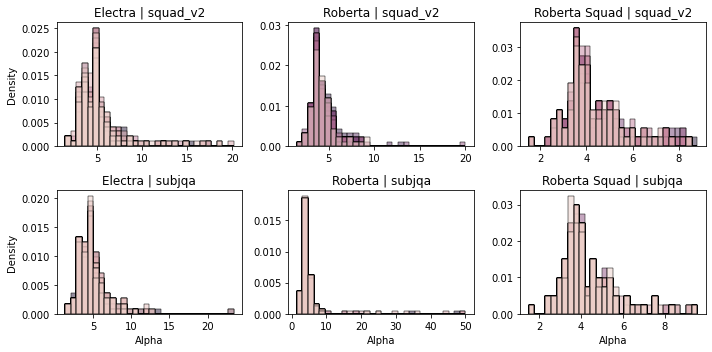

In [107]:
datasets = list(details_df.source_dataset.unique())
architectures = list(details_df.model_architecture.unique())
architectures.sort()

fig, axs = plt.subplots(len(datasets), len(architectures), figsize=(10,5))
for ds, arch in product(datasets, architectures):
    r = datasets.index(ds)
    c = architectures.index(arch)
    ax = axs[r, c]
    x = details_df[(details_df['source_dataset']==ds) & (details_df['model_architecture']==arch)]
    sns.histplot(data=x, x='alpha', hue='test_clean_f1_score', stat='density', ax=ax, bins=30)
    ax.set_title(f'{arch} | {ds}')
    ax.set_xlabel('Alpha')
    if c != 0:
        ax.set_ylabel('')
    if r != 1:
        ax.set_xlabel('')
    # if r != 1 or c != 2:
    #     ax.get_legend().remove()
    ax.get_legend().remove()
plt.tight_layout()
plt.savefig('alpha_by_acc.pdf', dpi=2000)

<AxesSubplot:xlabel='layer_id', ylabel='alpha'>

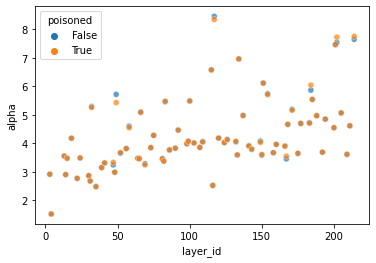

In [61]:
sns.scatterplot(data=x.groupby(['poisoned', 'layer_id'], as_index=False).agg({'alpha':'mean'}), x='layer_id', y='alpha', hue='poisoned', alpha=.7, )

missing models: 58


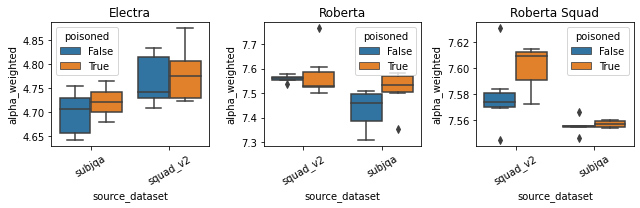

In [71]:
print(f'missing models: {len(metadata)-len(df)}')

fig, axs = plt.subplots(1,3, figsize=(9,3))
for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='alpha_weighted', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'{arch}')
plt.tight_layout()

missing models: 65


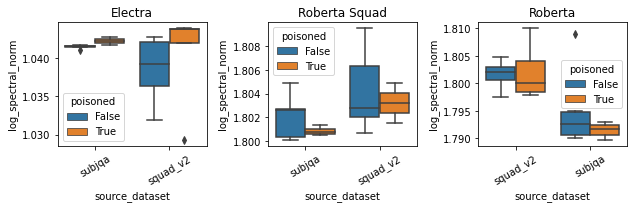

In [49]:
print(f'missing models: {len(metadata)-len(df)}')

fig, axs = plt.subplots(1,3, figsize=(9,3))
for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='log_spectral_norm', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'{arch}')
plt.tight_layout()

missing models: 65


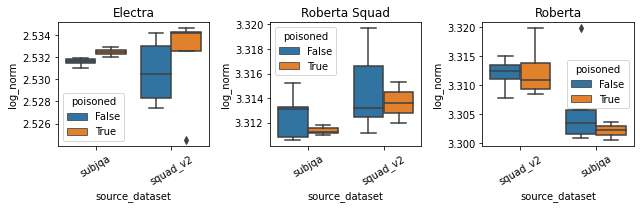

In [50]:
print(f'missing models: {len(metadata)-len(df)}')

fig, axs = plt.subplots(1,3, figsize=(9,3))
for i, arch in enumerate(df['model_architecture'].unique()):
    ax = axs[i]
    sns.boxplot(data=df[df['model_architecture']==arch], x='source_dataset', y='log_norm', hue='poisoned', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(f'{arch}')
plt.tight_layout()

In [30]:

df.columns


Index(['index', 'log_norm', 'alpha', 'alpha_weighted', 'log_alpha_norm',
       'log_spectral_norm', 'stable_rank', 'model_name', 'lambda',
       'master_seed', 'lr_scheduler_level', 'lr_scheduler', 'poisoned',
       'poisoned_level', 'model_architecture', 'model_architecture_level',
       'learning_rate_level', 'learning_rate', 'early_stopping',
       'loss_eps_level', 'loss_eps', 'early_stopping_epoch_count_level',
       'early_stopping_epoch_count', 'batch_size_level', 'batch_size',
       'validation_split_level', 'validation_split', 'source_dataset',
       'source_dataset_level', 'dropout_level', 'dropout',
       'actual_trojan_percentage', 'number_trojan_instances',
       'trigger_fraction_level', 'trigger_fraction', 'trigger_option_level',
       'trigger_option', 'trigger_type_level', 'trigger_type',
       'trigger_text_level', 'trigger_text', 'val_clean_datapoint_count',
       'val_poisoned_datapoint_count', 'test_clean_datapoint_count',
       'test_poisoned_datapoi

In [6]:
details_df = pd.read_csv('/scratch/utrerf/TrojAI/NLP/round8/ww_details/3.csv')
details_df[~details_df.warning.isna()][['layer_id','name','warning']]

,layer_id,name,warning
1,4,NaN,over-trained
39,115,NaN,under-trained
41,117,NaN,under-trained
47,134,NaN,under-trained
53,151,NaN,under-trained
70,201,NaN,under-trained
71,202,NaN,under-trained
75,214,NaN,under-trained


In [25]:
x = details_df[~details_df.warning.isna()][['model_name', 'poisoned','layer_id','name','warning']]
x.groupby(['poisoned', 'warning']).agg({'model_name':'count'})

AttributeError: module 'pandas' has no attribute 'display'

<AxesSubplot:xlabel='layer_id', ylabel='count'>

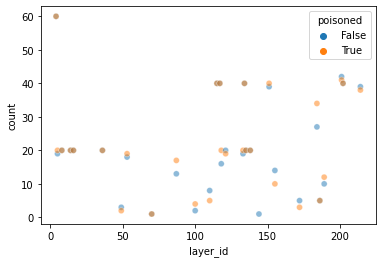

In [33]:
w = x.groupby(['layer_id', 'poisoned','warning'], as_index=False).agg({'model_name':'count'})
w = w.rename(columns={'model_name':'count'})
sns.scatterplot(data=w, x='layer_id', y='count', hue='poisoned', alpha=.5)